## E2: Bag of Words with multiple model answers

This notebook looks at the amount of gains to be had by looking at N=1-4 other model answers and using BoW techniques.

This is done by randomly choosing N other student responses which have an average score of 5.0 (perfect) and adding those a list which already
contains the model answer.

Then the student answer is compared to each of those N responses and the match with the highest score is taken. This is then used to automatically generate the score for the student response.

In [2]:
import sys
import numpy as np
sys.path.append('../')
import libs.utils as utils
import libs.stats as stats
import libs.preprocessing as pp
import libs.bag_of_words as bow
from importlib import reload
import spacy
reload(bow)

<module 'libs.bag_of_words' from '../libs/bag_of_words.py'>

## E1.1 : v2.0_en BoW with N=2 reference sentences

In [3]:
# Load Dataset
df2_en = utils.load_dataframe(language='en', version=2)
print(len(df2_en))

nlp_en = spacy.load('en')

2442


In [24]:
en_tokenizer = bow.create_bow_tokenizer(nlp_en)

def run_model(df, tokenizer, stop_words=pp.EN_STOPS, size=2):

    # convert the model answer from a 0-5 by 0.5 scale (11 possible scores) to a 0-5 by 1 scale (6 possible scores)
    y_true = list(map(round, df['Score'].tolist()))
    y_true_raw = df['Score'].tolist()
    y_pred = []
    y_pred_raw = []
    
    vec1 = bow.create_count_vectorizer(stop_words, tokenizer, ngram_range=(1,1))
    
    for index, row in df.iterrows():
        model_answer = row['Model Answer']
        model_answers = [model_answer]
        student_answer = row['Student Answer']
        
        # find other 5.0 level scores in student responses
        tmp = df[np.logical_and(df['Model Answer'] == model_answer, df['Student Answer'] != student_answer)]
        tmp = tmp[tmp['Score'] >= 5.0]['Student Answer'].tolist()
        
        if len(tmp) > 0:
            model_answers.extend(np.random.choice(tmp, size=size).tolist())
        
        dist_score = 0.0
        for ma in model_answers:
            dist = bow.get_sentence_distance(vec1, ma, student_answer)
            if np.isnan(dist):
                continue
            if dist > dist_score:
                dist_score = dist
        
        y_pred_raw.append(dist_score)
        y_pred.append(bow.round_score(dist_score))
        
    return {
        'y_true' : np.array(y_true),
        'y_true_raw' : np.array(y_true_raw),
        'y_pred' : np.array(y_pred),
        'y_pred_raw' : np.array(y_pred_raw)
    }

e11_res = run_model(df2_en, en_tokenizer, stop_words=pp.EN_STOPS, size=2)

/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Accuracy: 16.134%
Precision: 53.870%
Recall: 16.134%
F1-Measure: 20.199%
Pearson's R: 0.49
Cohen's Kappa: 0.03
RMSE: 2.11
MAE: 1.77
Y-True Mean: 4.15
Y-Pred Mean: 2.46
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.34


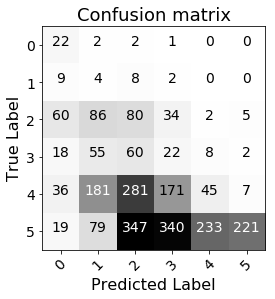

In [25]:
stats.print_big4(e11_res['y_true'], e11_res['y_pred'])
stats.print_stats(e11_res['y_true'], e11_res['y_pred'])
stats.plot_confusion_matrix(stats.cm(e11_res['y_true'], e11_res['y_pred']), classes=np.unique(e11_res['y_true']))

## E1.2 v2.0_en BoW Model Answers N = 3

In [26]:
e12_res = run_model(df2_en, en_tokenizer, stop_words=pp.EN_STOPS, size=3)

/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Accuracy: 18.059%
Precision: 54.142%
Recall: 18.059%
F1-Measure: 22.271%
Pearson's R: 0.50
Cohen's Kappa: 0.04
RMSE: 2.02
MAE: 1.66
Y-True Mean: 4.15
Y-Pred Mean: 2.57
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.35


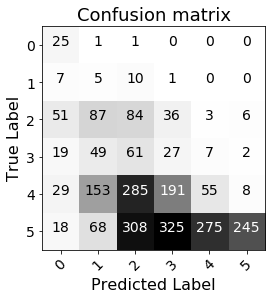

In [28]:
stats.print_big4(e12_res['y_true'], e12_res['y_pred'])
stats.print_stats(e12_res['y_true'], e12_res['y_pred'])
stats.plot_confusion_matrix(stats.cm(e12_res['y_true'], e12_res['y_pred']), classes=np.unique(e12_res['y_true']))

## E1.3 v2.0_en BoW Model Answers N = 4

In [29]:
e13_res = run_model(df2_en, en_tokenizer, stop_words=pp.EN_STOPS, size=4)

/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Accuracy: 18.305%
Precision: 54.237%
Recall: 18.305%
F1-Measure: 22.510%
Pearson's R: 0.52
Cohen's Kappa: 0.04
RMSE: 1.95
MAE: 1.60
Y-True Mean: 4.15
Y-Pred Mean: 2.63
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.33


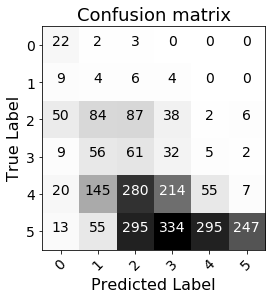

In [30]:
stats.print_big4(e13_res['y_true'], e13_res['y_pred'])
stats.print_stats(e13_res['y_true'], e13_res['y_pred'])
stats.plot_confusion_matrix(stats.cm(e13_res['y_true'], e13_res['y_pred']), classes=np.unique(e13_res['y_true']))

## E1.4 v2.0_en BoW Model Answers N = 3, NGrams=(1,2,3)

In [36]:

def run_multi_model(df, tokenizer, stop_words=pp.EN_STOPS, size=2):

    # convert the model answer from a 0-5 by 0.5 scale (11 possible scores) to a 0-5 by 1 scale (6 possible scores)
    y_true = list(map(round, df['Score'].tolist()))
    y_true_raw = df['Score'].tolist()
    y_pred = []
    y_pred_raw = []
    
    vec1 = bow.create_count_vectorizer(stop_words, tokenizer, ngram_range=(1,1))
    vec2 = bow.create_count_vectorizer(stop_words, tokenizer, ngram_range=(2,2))
    vec3 = bow.create_count_vectorizer(stop_words, tokenizer, ngram_range=(3,3))
    
    for index, row in df.iterrows():
        model_answer = row['Model Answer']
        model_answers = [model_answer]
        student_answer = row['Student Answer']
        
        # find other 5.0 level scores in student responses
        tmp = df[np.logical_and(df['Model Answer'] == model_answer, df['Student Answer'] != student_answer)]
        tmp = tmp[tmp['Score'] >= 5.0]['Student Answer'].tolist()
        
        if len(tmp) > 0:
            model_answers.extend(np.random.choice(tmp, size=size).tolist())
        
        dist_score = 0.0
        for ma in model_answers:
            d1 = bow.get_sentence_distance(vec1, ma, student_answer)
            
            try:
                d2 = bow.get_sentence_distance(vec2, ma, student_answer)
            except ValueError:
                d2 = 0.0
            try:
                d3 = bow.get_sentence_distance(vec3, ma, student_answer)
            except ValueError:
                d3 = 0.0
            
            total_score = 0.0
            power_index = 2
            for dist in [d1,d2,d3]:
                if np.isnan(dist):
                    continue
                total_score += np.power(dist, 1/power_index)
                power_index += 1
            
            pred_score = np.min([total_score / np.sqrt(3), 1.0])
            
            if pred_score > dist_score:
                dist_score = pred_score
        
        y_pred_raw.append(dist_score)
        y_pred.append(bow.round_score(dist_score))
        
    return {
        'y_true' : np.array(y_true),
        'y_true_raw' : np.array(y_true_raw),
        'y_pred' : np.array(y_pred),
        'y_pred_raw' : np.array(y_pred_raw)
    }

e14_res = run_multi_model(df2_en, en_tokenizer, stop_words=pp.EN_STOPS, size=3)

/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Accuracy: 33.210%
Precision: 50.878%
Recall: 33.210%
F1-Measure: 38.531%
Pearson's R: 0.49
Cohen's Kappa: 0.13
RMSE: 1.69
MAE: 1.24
Y-True Mean: 4.15
Y-Pred Mean: 3.19
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.54


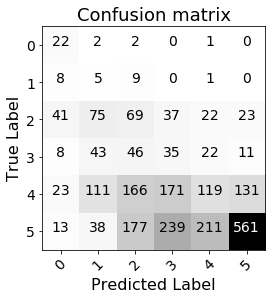

In [37]:
stats.print_big4(e14_res['y_true'], e14_res['y_pred'])
stats.print_stats(e14_res['y_true'], e14_res['y_pred'])
stats.plot_confusion_matrix(stats.cm(e14_res['y_true'], e14_res['y_pred']), classes=np.unique(e14_res['y_true']))

## E1.4 v2.0_en BoW Model Answers N = 3, NGrams=(1,2,3) Pass / Fail

Accuracy: 70.966%
Precision: 85.929%
Recall: 70.966%
F1-Measure: 75.533%
Pearson's R: 0.31
Cohen's Kappa: 0.26
RMSE: 0.54
MAE: 0.29
Y-True Mean: 0.87
Y-Pred Mean: 0.65
Y-True Std Deviation: 0.34
Y-Pred Std Deviation: 0.48


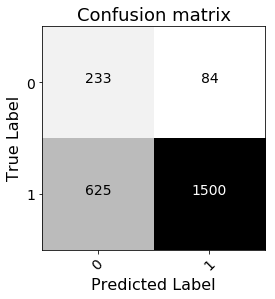

In [38]:
e14_res_y_true = e14_res['y_true'].copy()
e14_res_y_pred = e14_res['y_pred'].copy()

e14_res_y_true = utils.convert_to_pass_fail(e14_res_y_true)
e14_res_y_pred = utils.convert_to_pass_fail(e14_res_y_pred)

stats.print_big4(e14_res_y_true, e14_res_y_pred)
stats.print_stats(e14_res_y_true, e14_res_y_pred)
stats.plot_confusion_matrix(stats.cm(e14_res_y_true, e14_res_y_pred), classes=np.unique(e14_res_y_true))

## E1.5 v2.0_de BoW N=3, NGrams=(1,2,3)

2442


/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Accuracy: 21.294%
Precision: 48.436%
Recall: 21.294%
F1-Measure: 27.032%
Pearson's R: 0.39
Cohen's Kappa: 0.06
RMSE: 2.34
MAE: 1.87
Y-True Mean: 4.15
Y-Pred Mean: 2.44
Y-True Std Deviation: 1.12
Y-Pred Std Deviation: 1.65


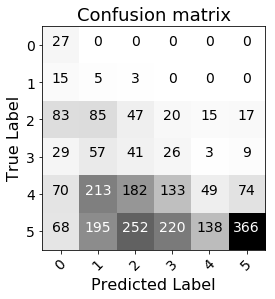

In [39]:
# Load Dataset
df2_de = utils.load_dataframe(language='de', version=2)
print(len(df2_de))

nlp_de = spacy.load('de')
de_tokenizer = bow.create_bow_tokenizer(nlp_de)

e15_res = run_multi_model(df2_de, de_tokenizer, stop_words=pp.DE_STOPS, size=3)

stats.print_big4(e15_res['y_true'], e15_res['y_pred'])
stats.print_stats(e15_res['y_true'], e15_res['y_pred'])
stats.plot_confusion_matrix(stats.cm(e15_res['y_true'], e15_res['y_pred']), classes=np.unique(e15_res['y_true']))

## E1.6 v2.0_de BoW N=3, NGrams=(1,2,3) Pass / Fail (GERMAN)

Accuracy: 52.539%
Precision: 85.297%
Recall: 52.539%
F1-Measure: 59.526%
Pearson's R: 0.21
Cohen's Kappa: 0.13
RMSE: 0.69
MAE: 0.47
Y-True Mean: 0.87
Y-Pred Mean: 0.44
Y-True Std Deviation: 0.34
Y-Pred Std Deviation: 0.50


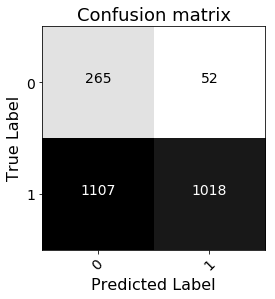

In [41]:
e15_res_y_true = e15_res['y_true'].copy()
e15_res_y_pred = e15_res['y_pred'].copy()

e15_res_y_true = utils.convert_to_pass_fail(e15_res_y_true)
e15_res_y_pred = utils.convert_to_pass_fail(e15_res_y_pred)

stats.print_big4(e15_res_y_true, e15_res_y_pred)
stats.print_stats(e15_res_y_true, e15_res_y_pred)
stats.plot_confusion_matrix(stats.cm(e15_res_y_true, e15_res_y_pred), classes=np.unique(e15_res_y_true))